In [13]:
%matplotlib inline

import ast

from neo4j import GraphDatabase

import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [14]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [15]:
uri = 'bolt://localhost:7687'
pwd = 'myneo4j'

conn = Neo4jConnection(uri=uri, user="neo4j", pwd=pwd)

conn.query("MATCH (n) RETURN COUNT(n)")


[<Record COUNT(n)=2708>]

In [24]:
from graphdatascience import GraphDataScience

gds = GraphDataScience(uri, auth=("neo4j",pwd))

In [16]:
query = """CREATE CONSTRAINT papers IF NOT EXISTS ON (p:Paper) ASSERT p.id IS UNIQUE"""

conn.query(query)

[]

In [17]:
query = """LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/cj2001/pydata2021/main/notebooks/data/cora_nodes.csv' AS line
           WITH line
           MERGE (p:Paper {id: line.id})
               ON CREATE SET p.subject = line.subject, p.features = line.features
           RETURN COUNT(*)
"""

conn.query(query)

[<Record COUNT(*)=2708>]

In [18]:
query = """LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/cj2001/pydata2021/main/notebooks/data/cora_edges.csv' AS line
           WITH line
           MATCH (source:Paper {id: line.source})
           MATCH (target:Paper {id: line.target})
           MERGE (source)-[:CITES]->(target)
           RETURN COUNT(*)
"""

conn.query(query)

[<Record COUNT(*)=5429>]

In [25]:

query = """CALL gds.graph.project(
                'cora',
                'Paper',
                {
                  CITES: 
                  {
                      orientation: 'UNDIRECTED'
                  }
               }
            )
            YIELD
                graphName, nodeProjection, nodeCount, relationshipProjection, relationshipCount
"""

gds.run_cypher(query)

,graphName,nodeProjection,nodeCount,relationshipProjection,relationshipCount
0,cora,"{'Paper': {'label': 'Paper', 'properties': {}}}",2708,"{'CITES': {'orientation': 'UNDIRECTED', 'aggre...",10858


In [26]:
def create_embs(dim=10):

    query = """CALL gds.fastRP.write(
               'cora',
               {
                   embeddingDimension: %d,
                   iterationWeights: [0.0, 0.0, 1.0, 1.0],
                   writeProperty: 'fastrp_embedding'
               }
           )
    """ % (dim)

    conn.query(query)
    return

def create_X_y():

    query = """MATCH (p:Paper) RETURN p.id AS id, p.subject AS subject, p.fastrp_embedding AS fastrp_embedding"""
    emb_df = pd.DataFrame([dict(_) for _ in conn.query(query)])
    emb_df['target'] = pd.factorize(emb_df['subject'])[0].astype("float32")
    y = emb_df['target'].to_numpy()
    emb_df['X'] = emb_df['fastrp_embedding'].apply(lambda x: np.array(x))
    X = np.array(emb_df['X'].to_list())

    return X, y

In [27]:
def modeler(dim, k_folds=5, model='linear', show_matrix=True):

    acc_scores = []

    create_embs(dim=dim)
    X, y = create_X_y()

    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        clf = svm.SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
        
    return

Accuracy scores:  [0.8552437223042836, 0.8567208271787297, 0.8375184638109305, 0.8330871491875923, 0.827178729689808]
Mean accuracy:  0.8419497784342689


/Users/vassilisanagnostopoulos/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


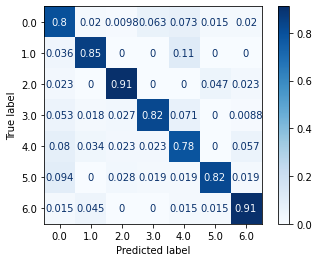

In [28]:
modeler(dim=256)